<a href="https://colab.research.google.com/github/Ashsam2310/Ashsam2310/blob/main/IPL_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 34 kB/s 
     |████████████████████████████████| 198 kB 53.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=d8c4cbbb24a1608cfad7dd3fce7a09d7139b9c3a24ebf8b4240ac4d95a1b0ee0
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [3]:
import pyspark

In [ ]:

from pyspark import SparkContext
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("CsvReader").getOrCreate()
csv_df = spark.read.format("csv").option("header", "true").load("/content/sample_data/ipl_venue.csv")
print(csv_df.head(2))

[Row(venue_id='1', venue='Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium', city='Visakhapatnam'), Row(venue_id='2', venue='Sharjah Cricket Stadium', city='Sharjah')]


In [ ]:
csv_df.printSchema()

root
 |-- venue_id: string (nullable = true)
 |-- venue: string (nullable = true)
 |-- city: string (nullable = true)



In [ ]:
csv_df.count()

35

In [ ]:
csv_df.columns

In [ ]:
spark.stop()

In [4]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
sc=SparkContext()
sqlc=SQLContext(sc)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [5]:
df1=sqlc.read.csv("/content/ipl_venue.csv",header=True)
df2=sqlc.read.csv("/content/ipl_matches.csv",header=True)
df3=sqlc.read.csv("ipl_ball_by_ball.csv",header=True)

In [ ]:
print(df1.count())
print(df2.count())
print(df3.count())


35
816
48929


In [ ]:
df2.show()

+--------+----------+---------------+--------+-------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+----------+------+-----------+--------------+
|match_id|      date|player_of_match|venue_id|neutral_venue|               team1|               team2|         toss_winner|toss_decision|              winner| result|result_margin|eliminator|method|    umpire1|       umpire2|
+--------+----------+---------------+--------+-------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+----------+------+-----------+--------------+
|  335982|2008-04-18|    BB McCullum|      35|            0|Royal Challengers...|Kolkata Knight Ri...|Royal Challengers...|        field|Kolkata Knight Ri...|   runs|          140|         N|    NA|  Asad Rauf|   RE Koertzen|
|  335983|2008-04-19|     MEK Hussey|      31|            0|     Kings XI Punjab| Chennai Super 

In [ ]:
df3.show()

+--------+------+-----+----+-------------+-------------+------------+------------+----------+----------+------------+---------+--------------+----------------+-------+-----------+--------------------+--------------------+
|match_id|inning|overs|ball|      batsman|  non_striker|      bowler|batsman_runs|extra_runs|total_runs|non_boundary|is_wicket|dismissal_kind|player_dismissed|fielder|extras_type|        batting_team|        bowling_team|
+--------+------+-----+----+-------------+-------------+------------+------------+----------+----------+------------+---------+--------------+----------------+-------+-----------+--------------------+--------------------+
|  419157|     2|   16|   4|      V Kohli|R Vinay Kumar|CRD Fernando|           0|         0|         0|           0|        0|            NA|              NA|     NA|         NA|Royal Challengers...|      Mumbai Indians|
|  419157|     2|   16|   5|      V Kohli|R Vinay Kumar|CRD Fernando|           1|         0|         1|        

In [24]:
df1.createOrReplaceTempView("venue")
df2.createOrReplaceTempView("match")
df3.createOrReplaceTempView("ball")

In [ ]:
sqlc.sql("""select venue.venue
    from 
        (select venue_id,count(*) as col1 
    from 
        (select * from match where eliminator = 'Y') group by venue_id order by col1 DESC LIMIT 3)
    as 
         t1 
    inner join 
        venue 
    on 
        t1.venue_id = venue.venue_id """).show()

+--------------------+
|               venue|
+--------------------+
|Dubai Internation...|
|MA Chidambaram St...|
|Sheikh Zayed Stadium|
+--------------------+



In [ ]:
sqlc.sql("""select fielder,count(*) as col1
    from (select * from ball where dismissal_kind='caught') group by fielder order by col1 DESC limit 1 """).show()

+--------+----+
| fielder|col1|
+--------+----+
|MS Dhoni|  36|
+--------+----+



In [ ]:
sqlc.sql("select bowler from ball where match_id in (select match_id from match where method='D/L') and dismissal_kind != 'run out' and dismissal_kind != 'retired hurt' and dismissal_kind != 'NA' and extras_type!= 'noballs' and is_wicket ='1' group by bowler order by count(*) DESC limit 1").show()

+-------+
| bowler|
+-------+
|M Ntini|
+-------+



In [26]:
sqlc.sql("select t1.batsman,100*t2.runs/t1.balls from (select batsman,count(*) as balls from ball where overs > 6 and extras_type != 'noballs' group by batsman) as t1 inner join (select batsman,sum(batsman_runs) as runs from ball where overs > 6 group by batsman) as t2 on t1.batsman = t2.batsman order by 100*t2.runs/t1.balls DESC limit 1").show()

+----------+----------------------+
|   batsman|((100 * runs) / balls)|
+----------+----------------------+
|B Stanlake|                 250.0|
+----------+----------------------+



In [ ]:
sqlc.sql("""
    select venue.venue,venue.city,t2.total_extras from venue inner join  
    (select match.venue_id,sum(t1.extras_sum) as total_extras from match join 
    (select match_id,sum(extra_runs) as extras_sum from ball group by match_id)as t1 on match.match_id = t1.match_id 
    group by match.venue_id order by total_extras DESC limit 1) as t2 on venue.venue_id = t2.venue_id
""").show()

+----------------+------+------------+
|           venue|  city|total_extras|
+----------------+------+------------+
|Wankhede Stadium|Mumbai|       361.0|
+----------------+------+------------+



In [ ]:
sqlc.sql("""
    select player_of_match from 
    (select player_of_match,count(*) as col1 from match where neutral_venue = 1 group by player_of_match) 
    where col1 = 
    (select max(col1) from (select player_of_match,count(*) as col1 from match 
     where neutral_venue = 1 group by player_of_match))
""").show()

+---------------+
|player_of_match|
+---------------+
|      YK Pathan|
|     GJ Maxwell|
|      JH Kallis|
|      JP Duminy|
+---------------+



In [ ]:
sqlc.sql("""
    select t1.batsman,t1.run_scored/t2.outs as average from 
    (select batsman,sum(batsman_runs) as run_scored from ball group by batsman) as t1 inner join 
    (select player_dismissed,count(*) as outs from ball where player_dismissed != 'NA' group by player_dismissed) as t2 on
    t1.batsman = t2.player_dismissed order by average DESC limit 10 
""").show()

+-------------+------------------+
|      batsman|           average|
+-------------+------------------+
|LA Pomersbach|             152.0|
|      HM Amla|              92.0|
|      TM Head|              77.0|
|     CH Gayle| 71.88888888888889|
|ST Jayasuriya| 68.66666666666667|
|    CH Morris|              68.5|
|    DA Miller|              64.0|
|   MEK Hussey|62.666666666666664|
|   RD Gaikwad|              57.0|
|     KL Rahul|              54.5|
+-------------+------------------+



In [ ]:
sqlc.sql("""
    select umpire1,u1+u2 from 
    (select umpire1,count(umpire1) as u1 from match group by umpire1)as t1 inner join
    (select umpire2,count(umpire2) as u2 from match group by umpire2)as t2 
    on t1.umpire1 = t2.umpire2 order by u1+u2 DESC limit 1
""").show()

+-------+---------+
|umpire1|(u1 + u2)|
+-------+---------+
| S Ravi|      121|
+-------+---------+



In [ ]:
sqlc.sql("""
    select venue.venue,venue.city,score from venue inner join 
    (select venue_id,score from match inner join 
    (select match_id,sum(batsman_runs) as score from ball where batsman = 'V Kohli' group by match_id 
    order by score DESC limit 1) as t1 where match.match_id = t1.match_id) as t2 on venue.venue_id = t2.venue_id
""").show()

+----------------+------+-----+
|           venue|  city|score|
+----------------+------+-----+
|Wankhede Stadium|Mumbai| 92.0|
+----------------+------+-----+



In [35]:
from pyspark.sql.functions import when
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("CsvReader").getOrCreate()
df_match = spark.read.format("csv").option("header", "true").load("/content/ipl_matches.csv",header=True)
df_match = df_match.withColumn('Wins toss and match',df_match.winner == df_match.toss_winner)
df_match = df_match.withColumn('Toss_Match',when(df_match['Wins toss and match'],'Win Both')\
                               .when(df_match['Wins toss and match'] == False ,'Lost Toss or Match'))
df_match = df_match.join(df1,on = "venue_id")


In [71]:
df_match.groupBy(df_match.Toss_Match).count().show()

+------------------+-----+
|        Toss_Match|count|
+------------------+-----+
|Lost Toss or Match|  398|
|          Win Both|  418|
+------------------+-----+



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
a=df_match.groupBy(df_match.Toss_Match).count().show()

+------------------+-----+
|        Toss_Match|count|
+------------------+-----+
|Lost Toss or Match|  398|
|          Win Both|  418|
+------------------+-----+



In [97]:
df=df_match.toPandas()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


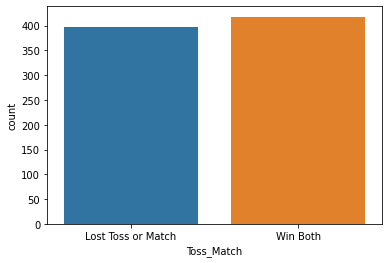

In [98]:
sns.countplot(df.Toss_Match)

In [100]:
import json
class Database():
    def __init__(self,loc):
        self.loc = loc
    def connect_to_db(self):
        self.connection = sqlite3.connect(self.loc)
        self.cursor = self.connection.cursor()
        print("Connection Established")
    def add_table(self,df,table_name,schema):
        # Add Dataframe as a table to Database 
        self.cursor.execute(f'''CREATE TABLE {table_name} ({schema})''')
        df = df.toPandas()
        df.to_sql(f'{table_name}', self.connection, if_exists='append', index = False)
        print(f"Loaded {table_name} into Database Successfully ")
    def drop_table(self,table_name):
        # Drop table from Database
        try:
            self.cursor.execute(f"""Drop table {table_name}""")
        except:
            print('Already Deleted')
    def execute_query(self,query):
        try :
            query_res = self.cursor.execute(f"""{query}""")
            return json.dumps(query_res.fetchall())
        except sqlite3.Error as err:
            print('Query Syntax Error')
            return None
    def get_status(self):
        try:
            self.connection.cursor()
            print('Connected')
        except :
            print('No Connection')
        return None
    def close(self):
        self.connection.close()

In [101]:
venue_schema = 'venue_id int,venue text,city text'
match_schema = 'match_id int,date text,player_of_match text,venue_id int,neutral_venue int,team1 text,team2 text,toss_winner text,toss_decision text,winner text,result text,result_margin text,eliminator text, method text,umpire1 text,umpire2 text'
ball_schema = 'match_id int, inning int, overs int, ball int, batsman text, non_striker text, bowler text, batsman_runs float, extra_runs float, total_runs float,non_boundary int,is_wicket int,dismissal_kind text,player_dismissed text,fielder text,extras_type text,batting_team text,bowling_team text'

In [102]:
import sqlite3
ipl = Database('data.db')
ipl.connect_to_db()
ipl.add_table(df1,'venue',venue_schema)
ipl.add_table(df2,'match',match_schema)
ipl.add_table(df3,'ball',ball_schema)

Connection Established
Loaded venue into Database Successfully 
Loaded match into Database Successfully 
Loaded ball into Database Successfully 


In [ ]:
ipl.execute_query("""select venue.venue
    from 
        (select venue_id,count(*) as col1 
    from 
        (select * from match where eliminator = 'Y') group by venue_id order by col1 DESC LIMIT 3)
    as 
         t1 
    inner join 
        venue 
    on 
        t1.venue_id = venue.venue_id """)

'[["Dubai International Cricket Stadium"], ["Sheikh Zayed Stadium"], ["Saurashtra Cricket Association Stadium"]]'

In [ ]:
ipl.execute_query("""select fielder,count(*) as col1
    from (select * from ball where dismissal_kind='caught') group by fielder order by col1 DESC limit 1 """)

'[["MS Dhoni", 36]]'

In [ ]:
ipl.execute_query("""select t1.batsman,100*t2.runs/t1.balls from (select batsman,count(*) as balls from ball where overs > 6 and extras_type != 'noballs' group by batsman) as t1 inner join (select batsman,sum(batsman_runs) as runs from ball where overs > 6 group by batsman) as t2 on t1.batsman = t2.batsman order by 100*t2.runs/t1.balls DESC limit 1""")

'[["LJ Wright", 309.09090909090907]]'

In [ ]:
ipl.execute_query("""select venue.venue,venue.city,t2.total_extras from venue inner join  
    (select match.venue_id,sum(t1.extras_sum) as total_extras from match join 
    (select match_id,sum(extra_runs) as extras_sum from ball group by match_id)as t1 on match.match_id = t1.match_id 
    group by match.venue_id order by total_extras DESC limit 1) as t2 on venue.venue_id = t2.venue_id""")

'[["Wankhede Stadium", "Mumbai", 361.0]]'

In [ ]:
ipl.execute_query(""" select player_of_match from 
    (select player_of_match,count(*) as col1 from match where neutral_venue = 1 group by player_of_match) 
    where col1 = 
    (select max(col1) from (select player_of_match,count(*) as col1 from match 
     where neutral_venue = 1 group by player_of_match))""")


'[["GJ Maxwell"], ["JH Kallis"], ["JP Duminy"], ["YK Pathan"]]'

In [ ]:
ipl.execute_query("""select t1.batsman,t1.run_scored/t2.outs as average from 
    (select batsman,sum(batsman_runs) as run_scored from ball group by batsman) as t1 inner join 
    (select player_dismissed,count(*) as outs from ball where player_dismissed != 'NA' group by player_dismissed) as t2 on
    t1.batsman = t2.player_dismissed order by average DESC limit 10 """)

'[["LA Pomersbach", 152.0], ["HM Amla", 92.0], ["TM Head", 77.0], ["CH Gayle", 71.88888888888889], ["ST Jayasuriya", 68.66666666666667], ["CH Morris", 68.5], ["DA Miller", 64.0], ["MEK Hussey", 62.666666666666664], ["RD Gaikwad", 57.0], ["KL Rahul", 54.5]]'

In [ ]:
ipl.execute_query("""select umpire1,u1+u2 from 
    (select umpire1,count(umpire1) as u1 from match group by umpire1)as t1 inner join
    (select umpire2,count(umpire2) as u2 from match group by umpire2)as t2 
    on t1.umpire1 = t2.umpire2 order by u1+u2 DESC limit 1""")

'[["S Ravi", 121]]'

In [ ]:
ipl.execute_query("""select venue.venue,venue.city,score from venue inner join 
    (select venue_id,score from match inner join 
    (select match_id,sum(batsman_runs) as score from ball where batsman = 'V Kohli' group by match_id 
    order by score DESC limit 1) as t1 where match.match_id = t1.match_id) as t2 on venue.venue_id = t2.venue_id""")

'[["Wankhede Stadium", "Mumbai", 92.0]]'

In [109]:
ipl.execute_query("""select count(*) from match where winner=toss_winner""")

'[[418]]'

In [108]:
ipl.execute_query("""select count(*) from match where winner!=toss_winner""")

'[[398]]'